In [0]:
import numpy as np
import matplotlib.pyplot as plt
import codecs, cv2, datetime, glob, itertools, keras, os, pickle
import re, sklearn, string, sys, time
import tensorflow as tf
from random import randint
from keras import backend as K, regularizers, optimizers
from keras.models import load_model, Sequential
from keras.layers import MaxPooling2D, Convolution2D, Activation, Dropout, Flatten, Dense, InputLayer
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [0]:
img_width  = 28
img_height = 28
channels   = 1

batch_size = 250
num_epochs = 80

classes = {0: 'Póló',1: 'Nadrág',2: 'Pulóver',3: 'Ruha',4: 'Kabát',5: 'Szandál',6: 'Ing',7: 'Cipő',8: 'Táska',9: 'Csizma'}
num_classes         = len(classes)
classes_fashion     = ['Póló','Nadrág','Pulóver','Ruha','Kabát','Szandál','Ing','Cipő','Táska','Csizma']

In [29]:

cnn = Sequential()
    
cnn.add(InputLayer(input_shape=(img_height,img_width,channels)))
    
cnn.add(BatchNormalization())
    
cnn.add(Convolution2D(64, (4, 4), padding='same', activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.1))
    
cnn.add(Convolution2D(64, (4, 4), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.3))

cnn.add(Flatten())

cnn.add(Dense(256, activation='relu'))
cnn.add(Dropout(0.5))
    
cnn.add(Dense(64, activation='relu'))
    
cnn.add(BatchNormalization())

cnn.add(Dense(num_classes, activation='softmax'))
cnn.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_5 (Batch (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        1088      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 11, 64)        65600     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 5, 5, 64)          0         
__________

In [0]:
def shaping(data, target):
    data = np.array(data, dtype=np.uint8)
    target = np.array(target, dtype=np.uint8)
    data = data.reshape(data.shape[0], img_height, img_width, channels)
    target = np_utils.to_categorical(target, num_classes)
    data = data.astype('float32')
    data /= 255
    return data, target

In [0]:
train_data_shaped, train_target_shaped  = shaping(x_train, y_train)
test_data_shaped, test_target_shaped    = shaping(x_test, y_test)

In [32]:
histories = []
#X_train, X_val, y_train, y_val = train_test_split(train_data_shaped, train_target_shaped, test_size=0.2, random_state=42)

history = cnn.fit(train_data_shaped,train_target_shaped,batch_size=batch_size,epochs=num_epochs,verbose=1,validation_data=(test_data_shaped, test_target_shaped))
    
histories.append(history.history)


Train on 60000 samples, validate on 10000 samples
Epoch 1/80
60000/60000 [==============================] - 5s 81us/step - loss: 0.6432 - acc: 0.7737 - val_loss: 0.3732 - val_acc: 0.8660
Epoch 2/80
60000/60000 [==============================] - 4s 65us/step - loss: 0.3701 - acc: 0.8671 - val_loss: 0.3241 - val_acc: 0.8822
Epoch 3/80
60000/60000 [==============================] - 4s 65us/step - loss: 0.3266 - acc: 0.8821 - val_loss: 0.2826 - val_acc: 0.8944
Epoch 4/80
60000/60000 [==============================] - 4s 64us/step - loss: 0.2983 - acc: 0.8910 - val_loss: 0.2673 - val_acc: 0.9020
Epoch 5/80
60000/60000 [==============================] - 4s 63us/step - loss: 0.2741 - acc: 0.9002 - val_loss: 0.2692 - val_acc: 0.8988
Epoch 6/80
60000/60000 [==============================] - 4s 64us/step - loss: 0.2616 - acc: 0.9039 - val_loss: 0.2469 - val_acc: 0.9083
Epoch 7/80
60000/60000 [==============================] - 4s 63us/step - loss: 0.2463 - acc: 0.9096 - val_loss: 0.2416 - val_acc

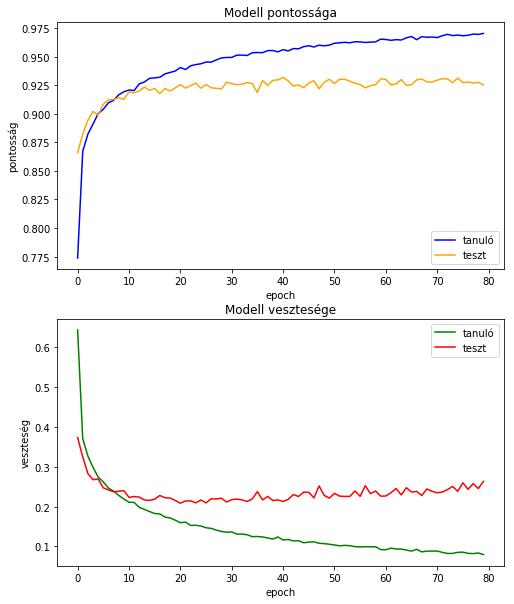

In [44]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,10))

ax1.set_title('Modell pontossága')
ax1.plot(histories[0]['acc'], color='blue')
ax1.plot(histories[0]['val_acc'], color='orange')
ax1.set_xlabel('epoch')
ax1.set_ylabel('pontosság')
ax1.legend(['tanuló', 'teszt'], loc='lower right')

ax2.set_title('Modell vesztesége')
ax2.plot(histories[0]['loss'], color ='green')
ax2.plot(histories[0]['val_loss'], color='red')
ax2.set_xlabel('epoch')
ax2.set_ylabel('veszteség')
ax2.legend(['tanuló', 'teszt'], loc='upper right')

plt.show()

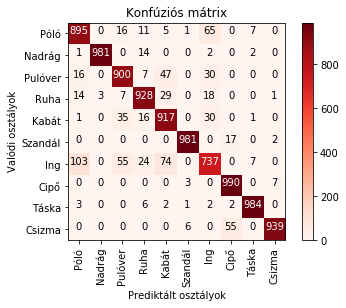

In [34]:
predictions = cnn.predict_classes(test_data_shaped, verbose=0)
cm=confusion_matrix(y_test, predictions)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
plt.title('Konfúziós mátrix')
tick_marks = np.arange(len(classes_fashion))
plt.xticks(tick_marks, classes_fashion, rotation=90)
plt.yticks(tick_marks, classes_fashion)

fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Valódi osztályok')
plt.xlabel('Prediktált osztályok')
plt.colorbar()
plt.show()
    

In [35]:
from sklearn.metrics import accuracy_score

print(classification_report(y_test, predictions))
print('Accuracy: ' + str(accuracy_score(y_test, predictions)))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88      1000
           1       1.00      0.98      0.99      1000
           2       0.89      0.90      0.89      1000
           3       0.92      0.93      0.93      1000
           4       0.85      0.92      0.88      1000
           5       0.99      0.98      0.98      1000
           6       0.83      0.74      0.78      1000
           7       0.93      0.99      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.99      0.94      0.96      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.92     10000
weighted avg       0.93      0.93      0.92     10000

Accuracy: 0.9252


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


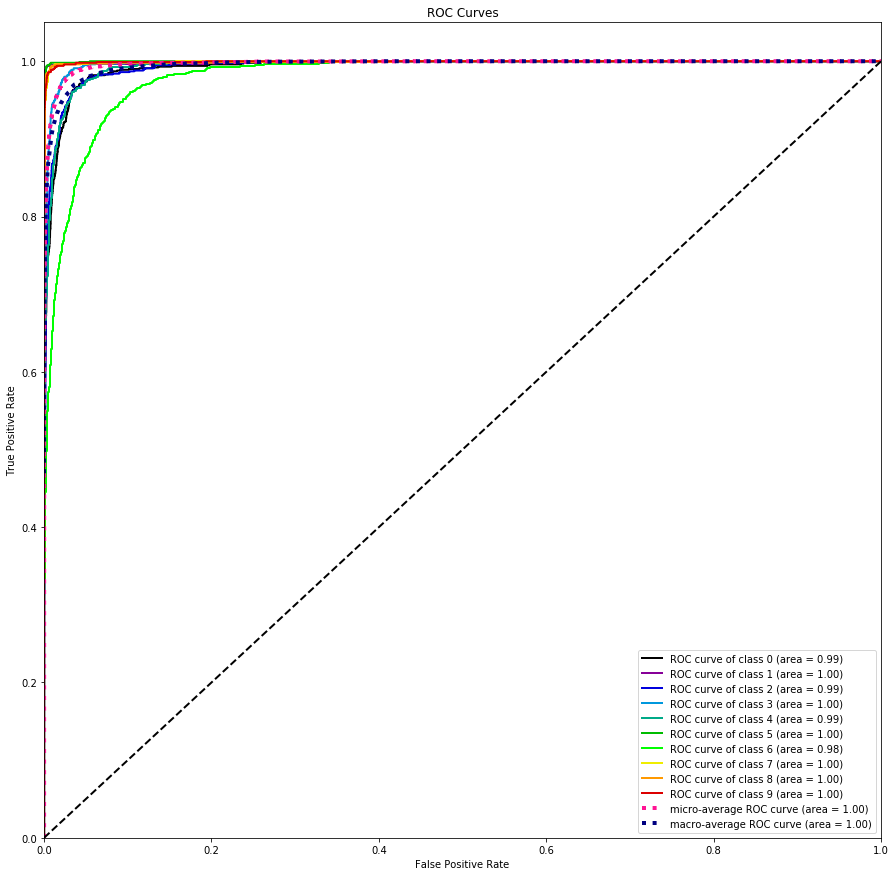

In [0]:
!pip install scikit-plot
import scikitplot as skplt

skplt.metrics.plot_roc_curve(y_test, cnn.predict(test_data_shaped), figsize=(15,15))
plt.show()

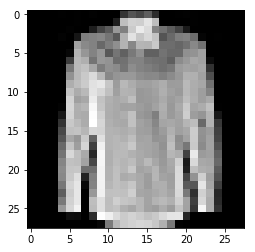

In [0]:
test_im = X_train[33669]
plt.imshow(test_im.reshape(28,28), cmap='gray', interpolation='none')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
  This is separate from the ipykernel package so we can avoid doing imports until


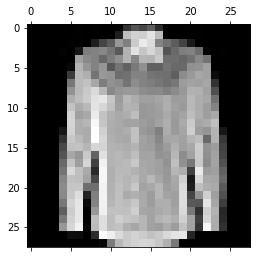

In [0]:
from keras import models
layer_outputs = [layer.output for layer in cnn.layers[:8]]
activation_model = models.Model(input=cnn.input, output=layer_outputs)
activations = activation_model.predict(test_im.reshape(1,28,28,1))

first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 0], cmap='gray')

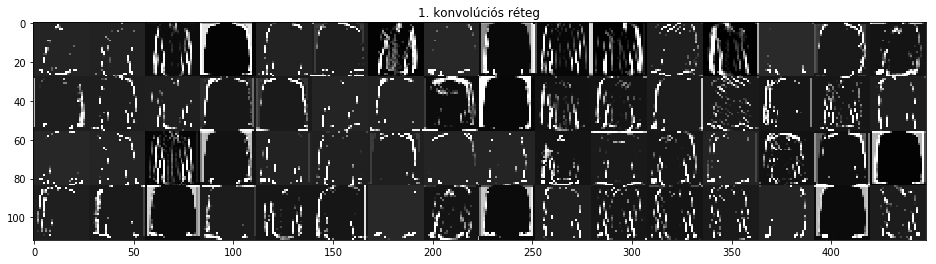

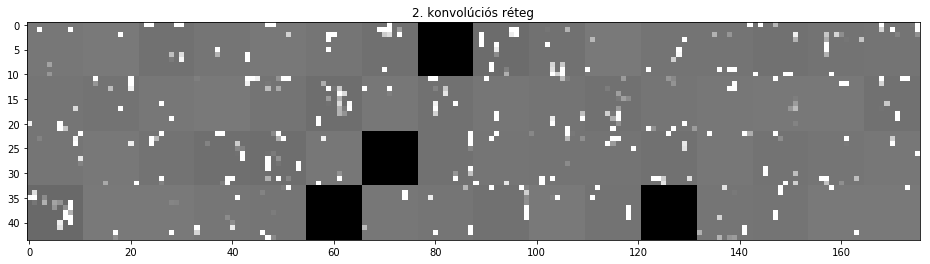

In [0]:
layer_names = []
for layer in cnn.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('conv'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name.replace('conv2d_','') + '. konvolúciós réteg')
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='gray')

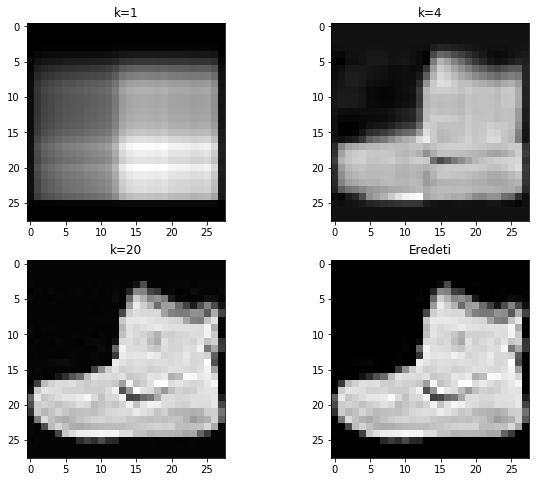

In [58]:
import numpy as np

U, sigma, V = np.linalg.svd(x_train[0])
reconstimg = np.matrix(U[:, :1]) * np.diag(sigma[:1]) * np.matrix(V[:1, :])

reconstimg4 = np.matrix(U[:, :4]) * np.diag(sigma[:4]) * np.matrix(V[:4, :])

reconstimg20 = np.matrix(U[:, :20]) * np.diag(sigma[:20]) * np.matrix(V[:20, :])

f, axes = plt.subplots(2,2, figsize=(10,8))
axes[1,1].imshow(x_train[0], cmap='gray', interpolation='none')
axes[1,1].set_title('Eredeti')

axes[0,0].imshow(reconstimg, cmap='gray', interpolation='none')
axes[0,0].set_title('k=1')

axes[0,1].imshow(reconstimg4, cmap='gray', interpolation='none')
axes[0,1].set_title('k=4')

axes[1,0].imshow(reconstimg20, cmap='gray', interpolation='none')
axes[1,0].set_title('k=20')

plt.show()